In [1]:
# !pip install nltk pandas seaborn scikit-learn langdetect transformers sacremoses --quiet
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --quiet

### Library Imports

In [2]:
import re
import nltk
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, GPT2ForSequenceClassification, GPT2Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from langdetect import detect, DetectorFactory
import warnings

# Download necessary nltk resources
nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')
nltk.download('wordnet')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
warnings.filterwarnings("ignore")
DetectorFactory.seed = 0

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
device

device(type='cuda')

### Loading and cleaning the dataset

In [4]:
path = "combined_arguments.csv"
df = pd.read_csv(path)
df

,Argument1,Argument2,Relation
0,All deductions and exemptions should be elimin...,The Stipend Model : Instead of the standard de...,Support
1,The Stipend Model : Instead of the standard de...,Citizens who don't make enough to support them...,Support
2,Citizens who don't make enough to support them...,Homelessness would no longer be an issue. Home...,Support
3,The Stipend Model : Instead of the standard de...,The Stipend System would help people who wish ...,Support
4,The Stipend Model : Instead of the standard de...,The Stipend System would support those at the ...,Support
...,...,...,...
67188,A zero carb diet consists of mostly fatty meat...,"All dietary fiber [149], which is vital for ma...",Support
67189,A zero carbohydrate diet [138].,A zero-carbohydrate diet is bad for the enviro...,Attack
67190,A zero-carbohydrate diet is bad for the enviro...,A zero carbohydrate diet produces significantl...,Support
67191,A zero-carbohydrate diet is bad for the enviro...,New technologies could alleviate the extent of...,Attack


In [5]:
def clean_text(text):
    # Remove references such as -> See 1.1.3.1.3.1.
    text = re.sub(r'-> See (\d+\.)+(\d+)(,\s*)?', '', text)
    # Remove patterns like [12], [1], [138]
    text = re.sub(r'\[\d+\]', '', text)
    if text:
        # Lowercase
        text = text.lower()
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(f"[{string.punctuation}]", "", text)
        # Tokenize the text
        tokens = word_tokenize(text.lower())
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        text = " ".join(token for token in tokens)
    return text

In [6]:
df['Argument1'] = df['Argument1'].apply(clean_text)
df['Argument2'] = df['Argument2'].apply(clean_text)

Remove any row with empty Arg1, Arg2 or Relation

In [7]:
df = df[~df.applymap(lambda x: x == '').any(axis=1)]
df

,Argument1,Argument2,Relation
0,deductions exemptions eliminated us system inc...,stipend model instead standard deduction provi...,Support
1,stipend model instead standard deduction provi...,citizens dont make enough support would enough...,Support
2,citizens dont make enough support would enough...,homelessness would longer issue homeless encam...,Support
3,stipend model instead standard deduction provi...,stipend system would help people wish seek par...,Support
4,stipend model instead standard deduction provi...,stipend system would support lowest end income...,Support
...,...,...,...
67188,zero carb diet consists mostly fatty meat wate...,dietary fiber vital maintaining bacteria colon...,Support
67189,zero carbohydrate diet,zerocarbohydrate diet bad environment indirect...,Attack
67190,zerocarbohydrate diet bad environment indirect...,zero carbohydrate diet produces significantly ...,Support
67191,zerocarbohydrate diet bad environment indirect...,new technologies could alleviate extent damage...,Attack


### Data Exploration

Plot the distribution of the relations

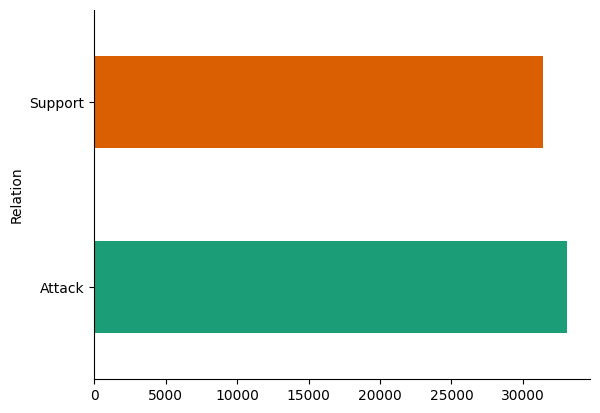

In [8]:
# Plot the graph
df.groupby('Relation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Visualise the similarity between pairs of arguments based on relation

<Figure size 1500x500 with 0 Axes>

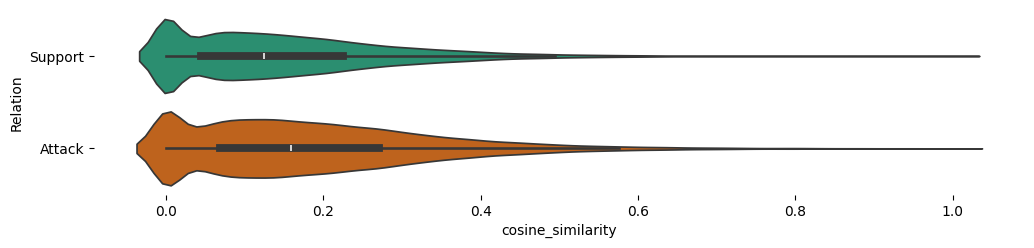

In [9]:
# Vectorize arguments using TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Concatenate arguments into a single list for TF-IDF fitting
all_text = df['Argument1'].tolist() + df['Argument2'].tolist()
tfidf_vectorizer.fit(all_text)

# Transform both argument columns into TF-IDF matrices
tfidf_arg1 = tfidf_vectorizer.transform(df['Argument1'])
tfidf_arg2 = tfidf_vectorizer.transform(df['Argument2'])

# Calculate cosine similarity between argument pairs
df['cosine_similarity'] = [cosine_similarity(tfidf_arg1[i], tfidf_arg2[i])[0][0] for i in range(len(df))]

plt.figure(figsize=(15, 5))

# Boxplot for cosine similarity distribution based on Relation
figsize = (12, 1.2 * len(df['Relation'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='cosine_similarity', y='Relation', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Languages used in the arguments

In [10]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unk'
    
df['Language1'] = df['Argument1'].apply(detect_language)
df['Language2'] = df['Argument2'].apply(detect_language)

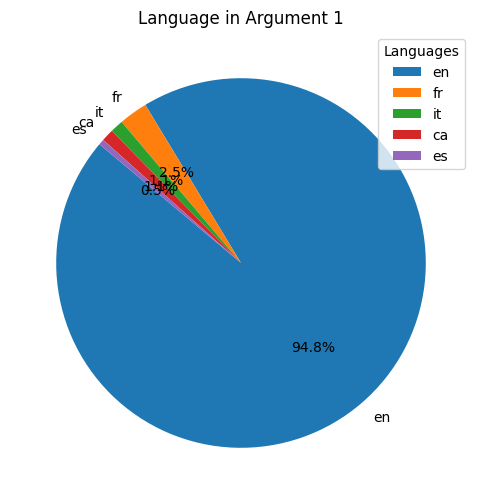

In [11]:
plt.figure(figsize=(8, 6))
language_counts = df["Language1"].value_counts()[:5]
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Language in Argument 1')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(language_counts.index, title='Languages', loc='upper right')

plt.show()

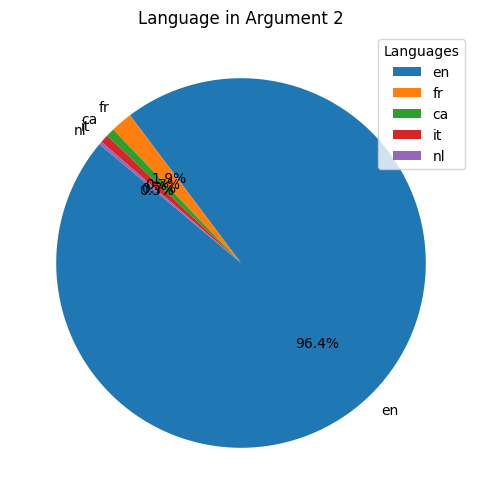

In [12]:
plt.figure(figsize=(8, 6))
language_counts = df["Language2"].value_counts()[:5]
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Language in Argument 2')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.legend(language_counts.index, title='Languages', loc='upper right')

plt.show()

In [13]:
df = df[(df["Language1"] == 'en') & (df["Language2"] == 'en')]
df

,Argument1,Argument2,Relation,cosine_similarity,Language1,Language2
0,deductions exemptions eliminated us system inc...,stipend model instead standard deduction provi...,Support,0.084879,en,en
1,stipend model instead standard deduction provi...,citizens dont make enough support would enough...,Support,0.181638,en,en
2,citizens dont make enough support would enough...,homelessness would longer issue homeless encam...,Support,0.046633,en,en
3,stipend model instead standard deduction provi...,stipend system would help people wish seek par...,Support,0.126692,en,en
4,stipend model instead standard deduction provi...,stipend system would support lowest end income...,Support,0.129821,en,en
...,...,...,...,...,...,...
67187,diet completely lacking carbohydrates unhealthy,zero carb diet consists mostly fatty meat wate...,Support,0.068543,en,en
67188,zero carb diet consists mostly fatty meat wate...,dietary fiber vital maintaining bacteria colon...,Support,0.073980,en,en
67190,zerocarbohydrate diet bad environment indirect...,zero carbohydrate diet produces significantly ...,Support,0.077998,en,en
67191,zerocarbohydrate diet bad environment indirect...,new technologies could alleviate extent damage...,Attack,0.000000,en,en


### Sauvegarde du jeu de données

In [14]:
df.to_csv("arguments_dataset_cleaned.csv")